In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats
import pylab

In [11]:
# Load the data from the CSV file
sales_data = pd.read_csv('sales_data.csv')
sales_data.head(10)

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear,datetime
0,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06,2011-05-31
1,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06,2011-05-31
2,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06,2011-05-31
3,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06,2011-05-31
4,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06,2011-05-31
5,1,3578.2700,3578.2700,3953.9884,Bikes,United States,1.051085e+07,5.366576e+06,2011-06-01
6,1,3578.2700,3578.2700,3953.9884,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
7,1,3374.9900,3374.9900,3729.3640,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
8,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
9,1,3578.2700,3578.2700,3953.9884,Bikes,United States,1.051085e+07,5.366576e+06,2011-06-02


In [12]:
# Convert 'datetime' column to datetime type
sales_data['datetime'] = pd.to_datetime(sales_data['datetime'])

# Set 'datetime' as the index
sales_data.set_index('datetime', inplace=True)
sales_data.head()

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06
2011-05-31,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06


In [13]:
countries = sales_data['Country'].unique()
countries

array(['Canada', 'France', 'United States', 'Australia', 'United Kingdom',
       'Germany'], dtype=object)

In [14]:
sales_data_country = {country: sales_data[sales_data['Country'] == country] for country in countries}


sales_data_country[countries[0]]
    

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-18,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-23,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-24,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-29,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
...,...,...,...,...,...,...,...,...
2014-06-30,1,21.98,21.98,34.2219,Accessories,Canada,6.771829e+06,5693988.86
2014-06-30,1,8.99,8.99,34.2219,Clothing,Canada,6.771829e+06,5693988.86
2014-06-30,1,21.98,21.98,209.9169,Accessories,Canada,6.771829e+06,5693988.86


In [15]:
# Resample 'TotalDue' for each country in the dictionary
monthly_sales_by_country = {
    country: data['TotalDue'].resample('ME').sum() for country, data in sales_data_country.items()
}

# Example: Access the resampled data for the first country
first_country = countries[0]
print(f"Monthly sales for country '{first_country}':")
print(monthly_sales_by_country[first_country]) 

Monthly sales for country 'Canada':
datetime
2011-05-31    2.395443e+06
2011-06-30    2.031782e+04
2011-07-31    4.512899e+06
2011-08-31    7.471918e+06
2011-09-30    1.318235e+04
2011-10-31    1.216474e+07
2011-11-30    4.008776e+04
2011-12-31    2.951436e+06
2012-01-31    9.267895e+06
2012-02-29    5.144809e+06
2012-03-31    7.162063e+06
2012-04-30    4.784907e+06
2012-05-31    3.182959e+07
2012-06-30    2.749437e+07
2012-07-31    2.656807e+07
2012-08-31    1.823936e+07
2012-09-30    1.852332e+07
2012-10-31    1.934808e+07
2012-11-30    9.507634e+06
2012-12-31    8.394028e+06
2013-01-31    1.055846e+07
2013-02-28    1.947355e+07
2013-03-31    1.839098e+07
2013-04-30    1.810397e+07
2013-05-31    2.315323e+07
2013-06-30    2.212995e+07
2013-07-31    3.095634e+07
2013-08-31    1.611709e+07
2013-09-30    1.378287e+07
2013-10-31    2.673192e+07
2013-11-30    7.339794e+06
2013-12-31    7.924098e+06
2014-01-31    1.346066e+07
2014-02-28    2.559653e+05
2014-03-31    2.818234e+07
2014-04-30

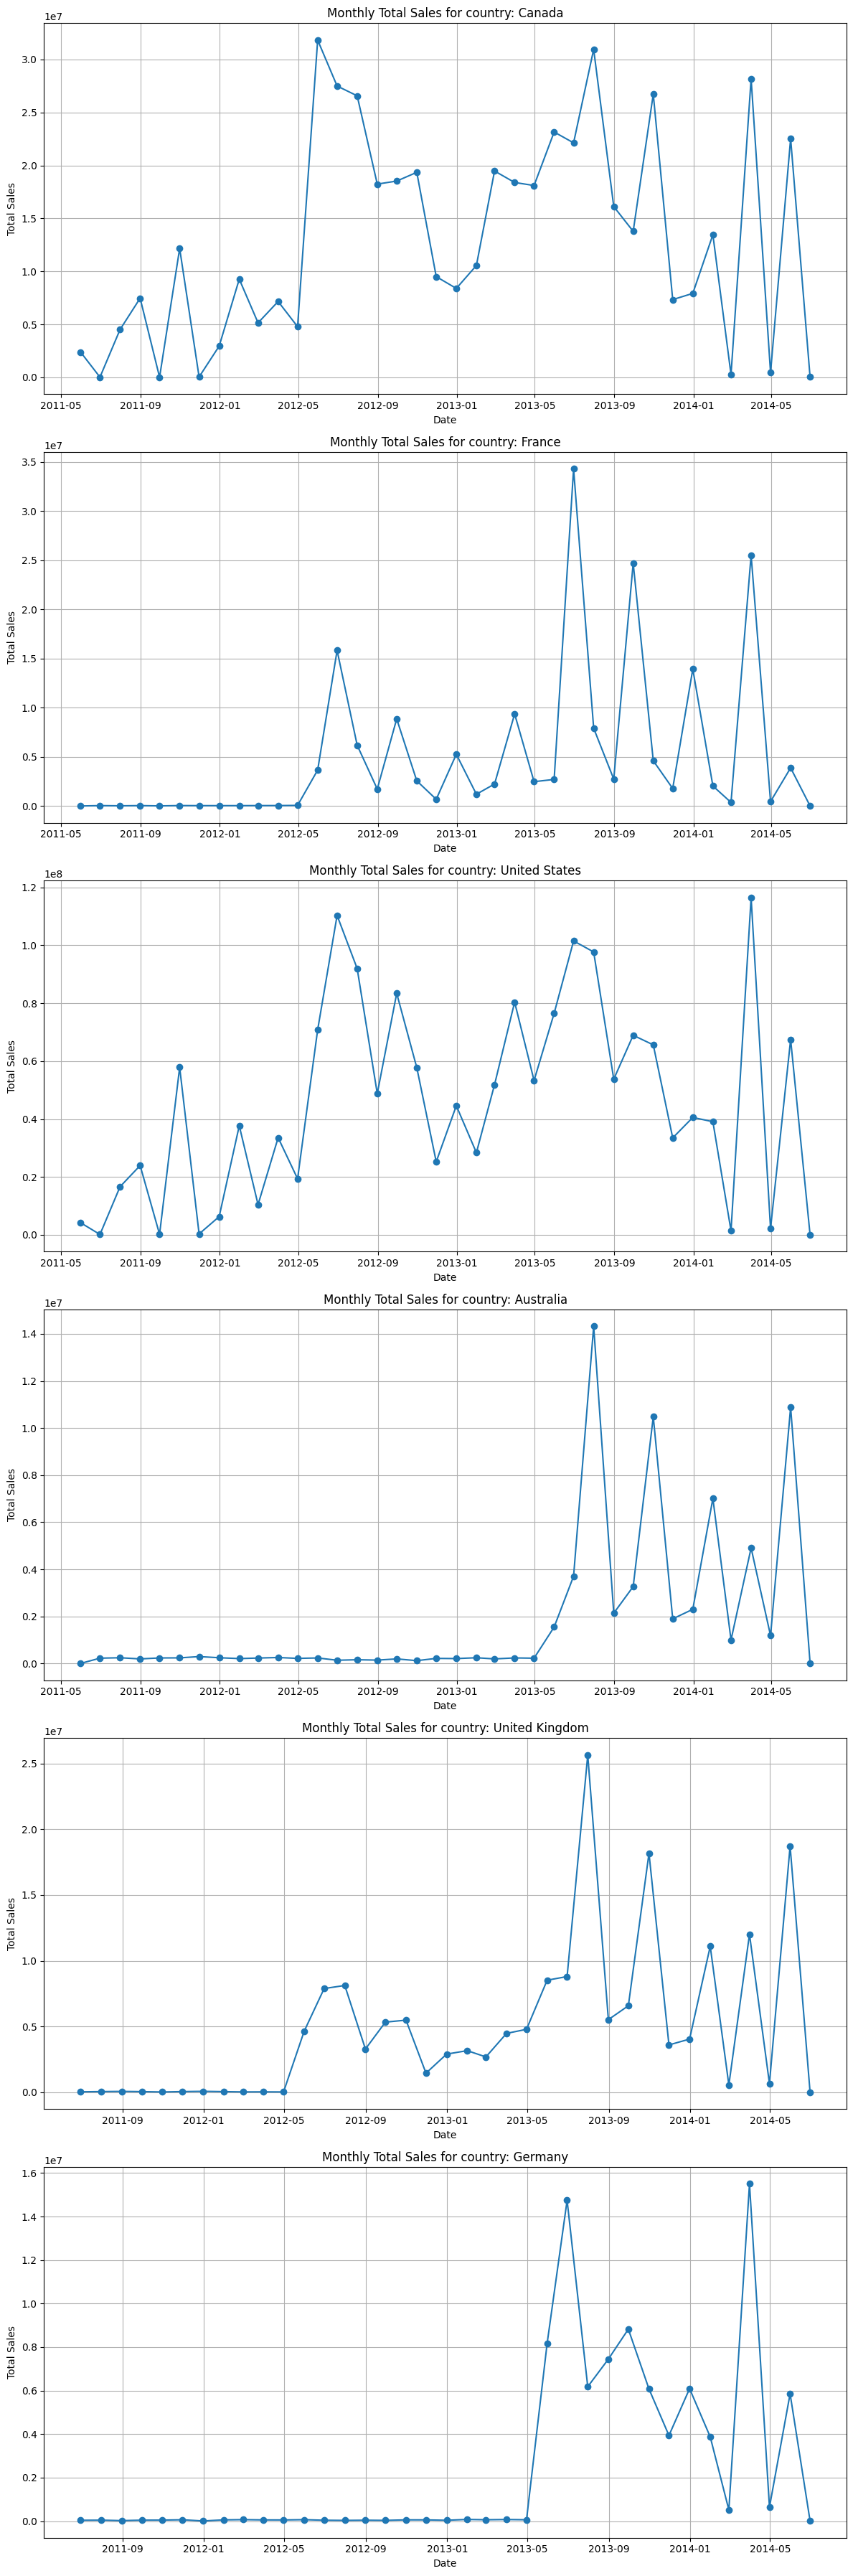

In [16]:
n_countries = len(countries)  # Total number of countries

plt.figure(figsize=(12, 6 * n_countries))  # Adjust figure size dynamically based on the number of countries

for i, (country, monthly_sales) in enumerate(monthly_sales_by_country.items(), 1):
    plt.subplot(n_countries, 1, i)
    plt.plot(monthly_sales, marker='o', linestyle='-')
    plt.title(f"Monthly Total Sales for country: {country}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [26]:
def adf_test(series):
    """
    If p-value > 0.05: The time series is non-stationary.
    If p-value ≤ 0.05: The time series is stationary.
    """
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value (%s): %.3f' % (key, value))


# Perform ADF test
for (country, data) in monthly_sales_by_country.items():
    print(f'{country}')
    adf_test(data)

Canada
ADF Statistic: -12.587343202483249
p-value: 1.853451064524835e-23
Critical Value (1%): -3.627
Critical Value (5%): -2.946
Critical Value (10%): -2.612
France
ADF Statistic: -11.828681363387517
p-value: 8.088077186361687e-22
Critical Value (1%): -3.633
Critical Value (5%): -2.949
Critical Value (10%): -2.613
United States
ADF Statistic: -12.048279405697174
p-value: 2.633594005090709e-22
Critical Value (1%): -3.627
Critical Value (5%): -2.946
Critical Value (10%): -2.612
Australia
ADF Statistic: -8.81859209610539
p-value: 1.90431036718964e-14
Critical Value (1%): -3.633
Critical Value (5%): -2.949
Critical Value (10%): -2.613
United Kingdom
ADF Statistic: -5.1834789100601055
p-value: 9.501214990008473e-06
Critical Value (1%): -3.627
Critical Value (5%): -2.946
Critical Value (10%): -2.612
Germany
ADF Statistic: -4.320744732110051
p-value: 0.0004088693153802782
Critical Value (1%): -3.738
Critical Value (5%): -2.992
Critical Value (10%): -2.636


In [24]:
#return p value
def calculate_p_value(data):
    """
    If p-value > 0.05: The time series is non-stationary.
    If p-value ≤ 0.05: The time series is stationary.
    """
    result = adfuller(data)
    return result[1]



#Make the time series stationary
for (country, data) in monthly_sales_by_country.items():
    p_value = calculate_p_value(data)
    
    if p_value > 0.05:
        print(f"\ncountry: {country}")
        differenced_data = data.diff().dropna()
        monthly_sales_by_country[country] = differenced_data
        print(calculate_p_value(differenced_data))


country: Germany
0.0004088693153802782


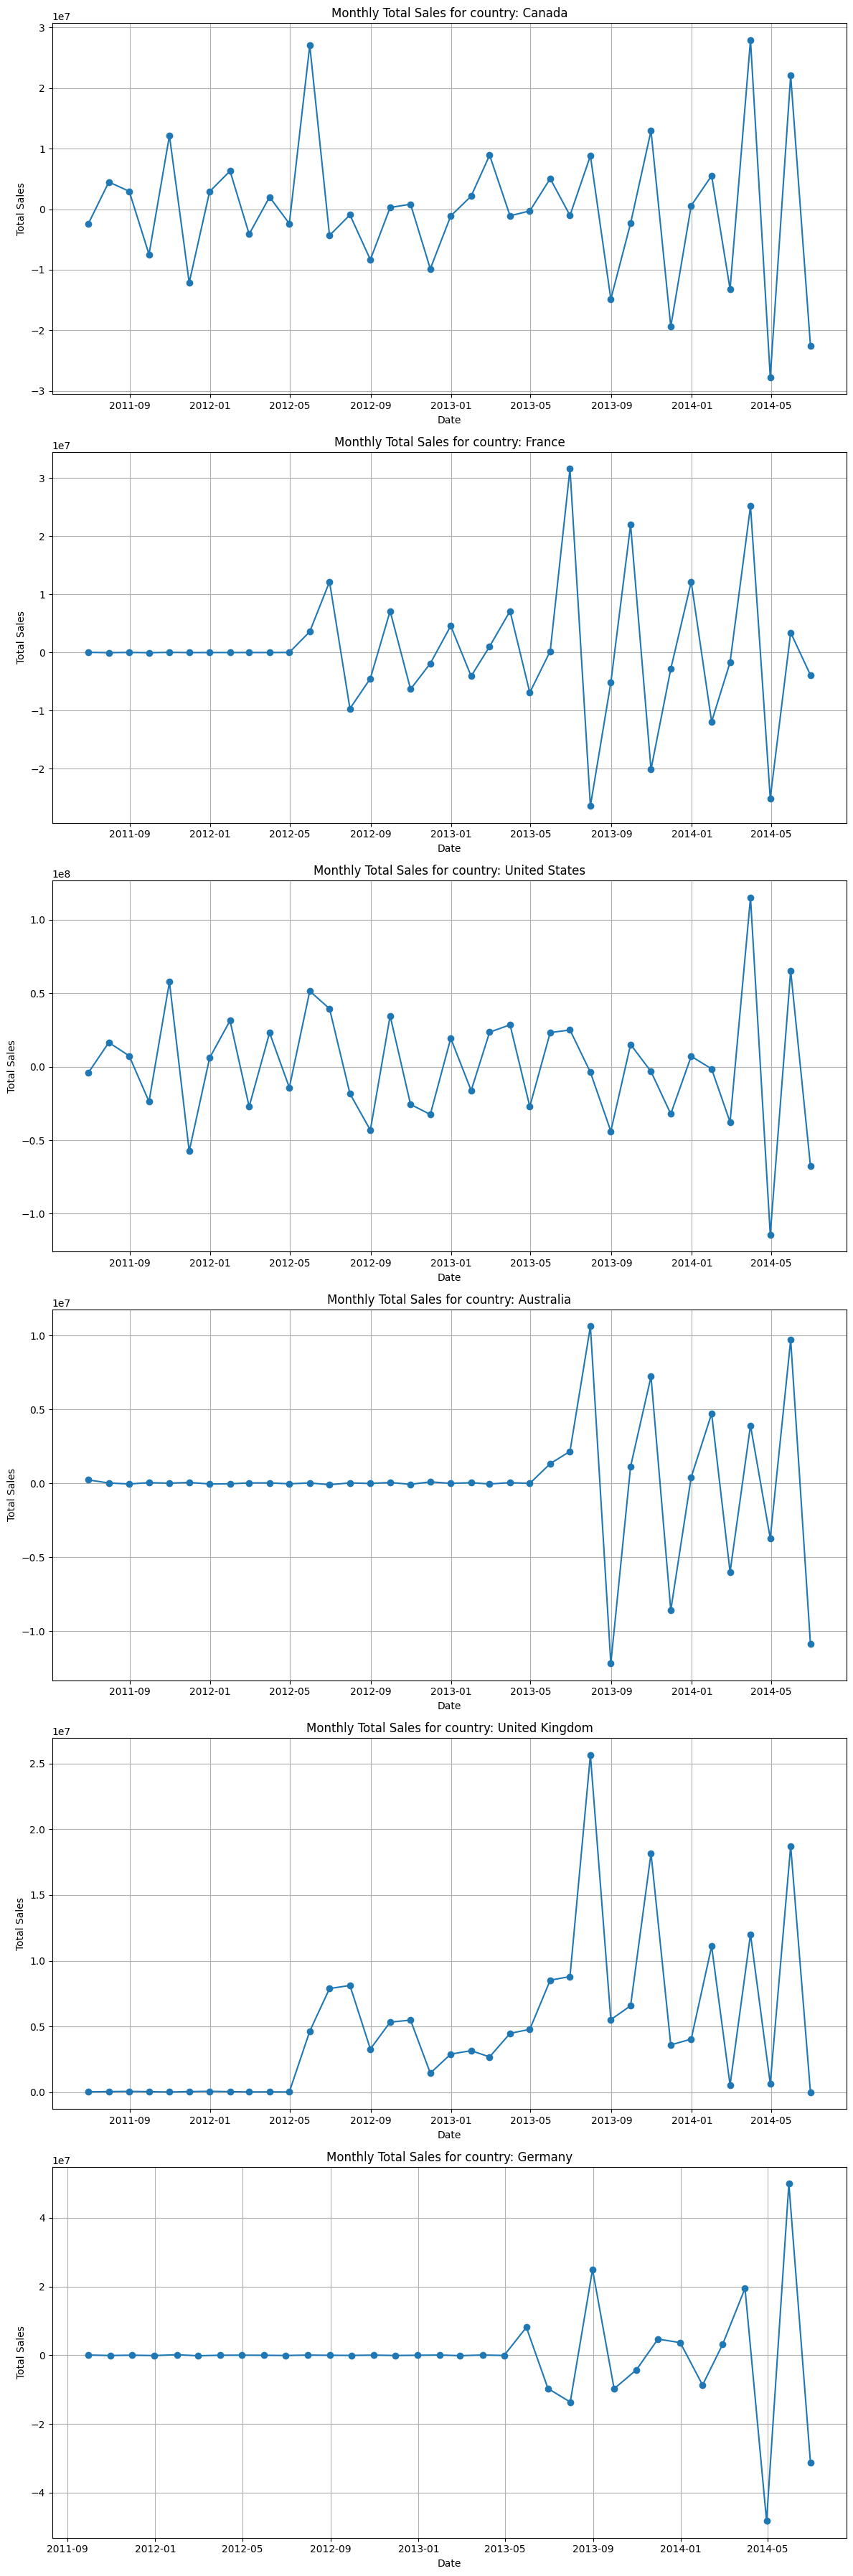

In [25]:
n_countries = len(countries)  # Total number of countries

plt.figure(figsize=(12, 6 * n_countries))  # Adjust figure size dynamically based on the number of countries

for i, (country, monthly_sales) in enumerate(monthly_sales_by_country.items(), 1):
    plt.subplot(n_countries, 1, i)
    plt.plot(monthly_sales, marker='o', linestyle='-')
    plt.title(f"Monthly Total Sales for country: {country}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

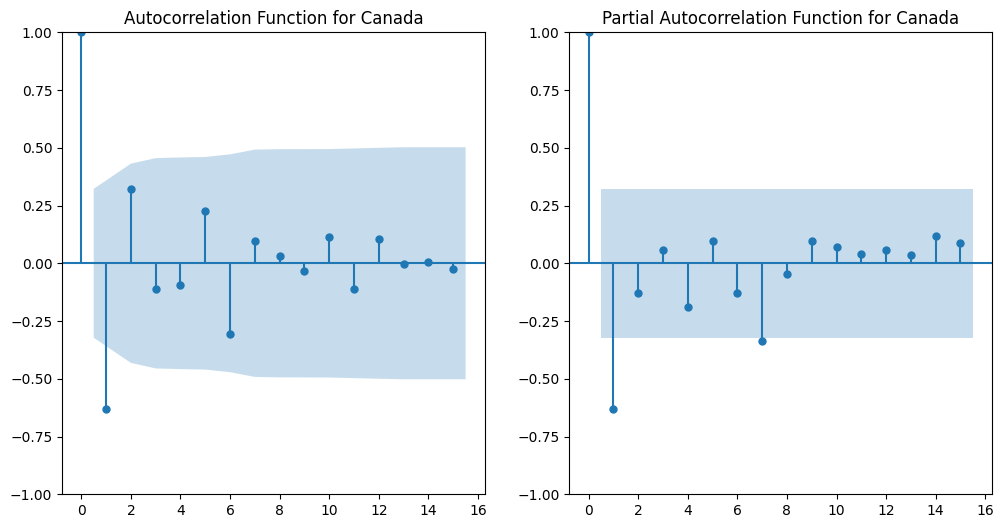

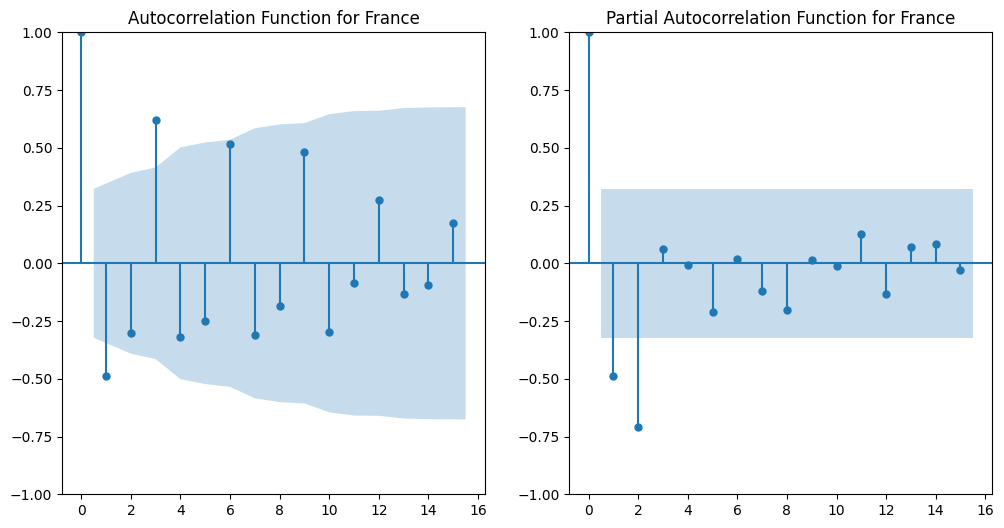

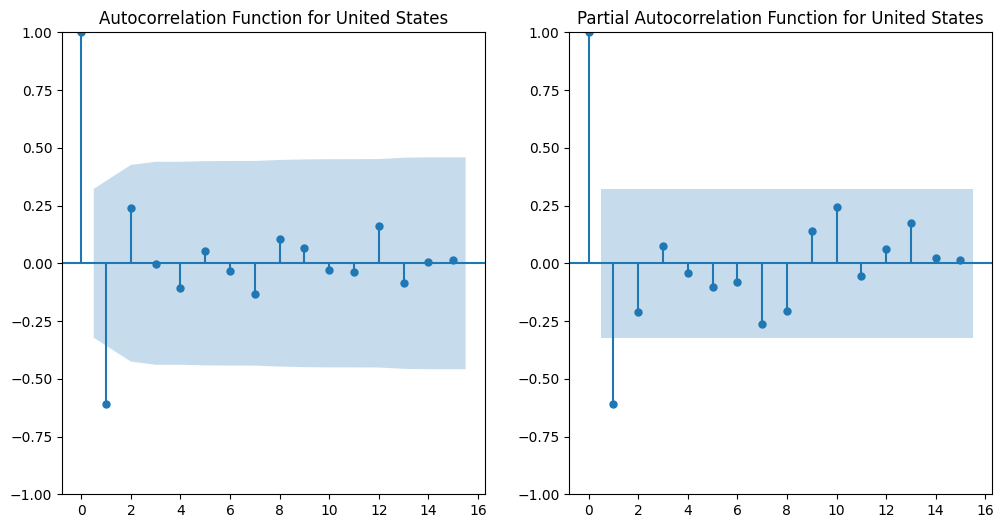

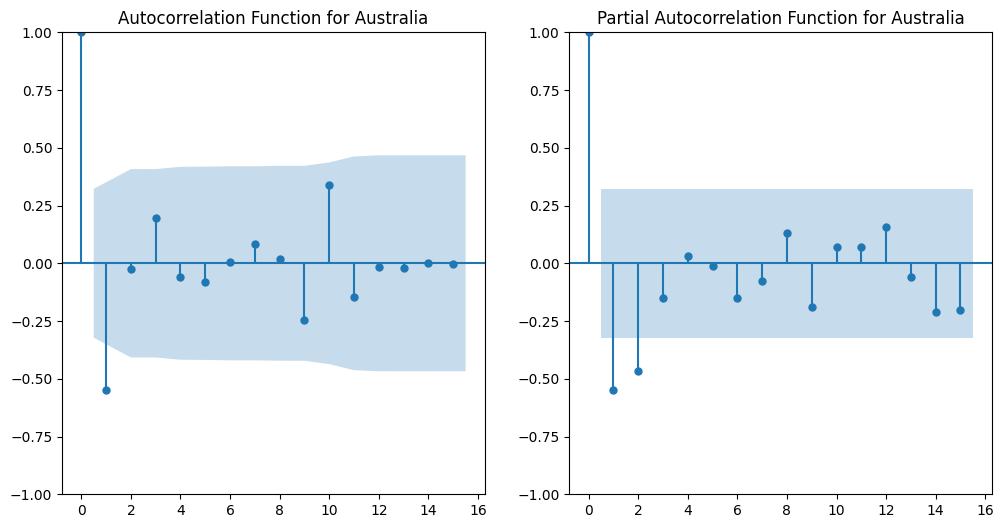

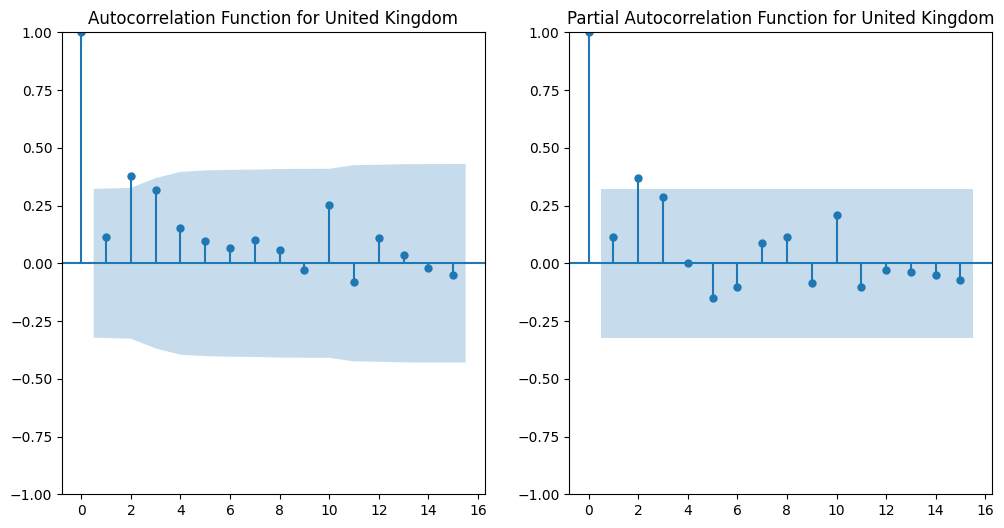

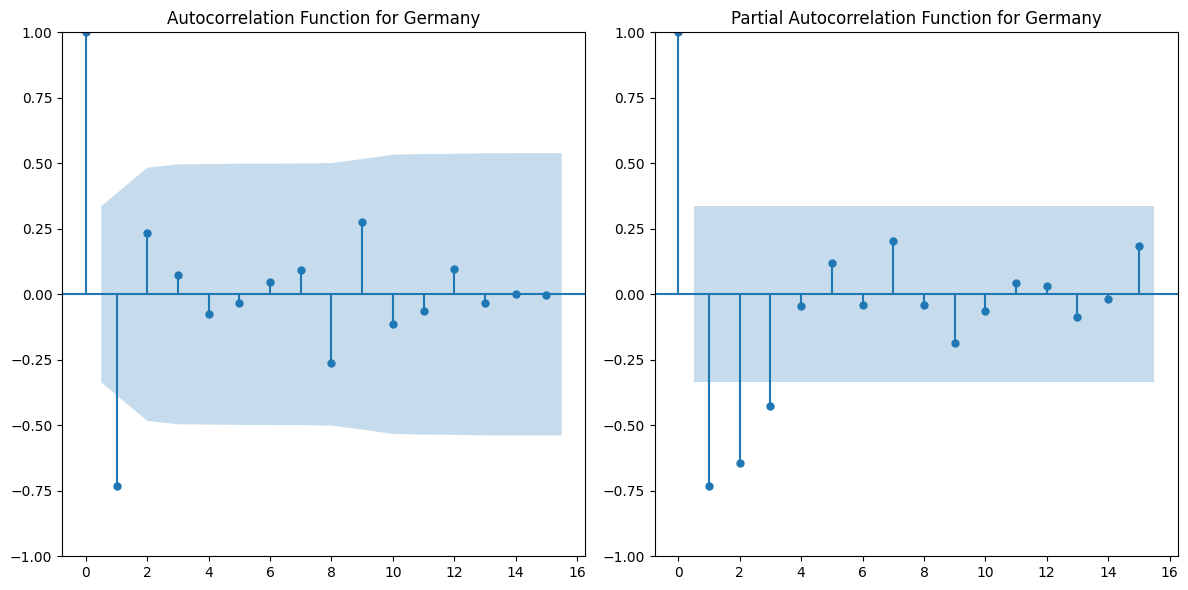

In [27]:
# Define maximum lags (adjust as necessary)
max_lags = 15

# Loop through each country and plot ACF and PACF
for country, monthly_sales in monthly_sales_by_country.items():
    plt.figure(figsize=(12, 6))
    
    # Plot ACF
    plt.subplot(121)
    plot_acf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Autocorrelation Function for {country}')
    
    # Plot PACF
    plt.subplot(122)
    plot_pacf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Partial Autocorrelation Function for {country}')
    
plt.tight_layout()
plt.show()

In [28]:
countries

array(['Canada', 'France', 'United States', 'Australia', 'United Kingdom',
       'Germany'], dtype=object)

In [29]:
model_countries = {}

model_countries[countries[0]] = ARIMA(monthly_sales_by_country[countries[0]], order=(7, 0, 1))
model_countries[countries[1]] = ARIMA(monthly_sales_by_country[countries[1]], order=(2, 0, 3))
model_countries[countries[2]] = ARIMA(monthly_sales_by_country[countries[2]], order=(1, 0, 1))
model_countries[countries[3]] = ARIMA(monthly_sales_by_country[countries[3]], order=(2, 0, 1))
model_countries[countries[4]] = ARIMA(monthly_sales_by_country[countries[4]], order=(2, 0, 2))
model_countries[countries[5]] = ARIMA(monthly_sales_by_country[countries[5]], order=(3, 0, 1))

In [32]:
model_fit_countries = {}

for (country, model) in model_countries.items():
    print(country)
    model_fit_countries[country] = model_countries[country].fit()

Canada
France


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


United States
Australia
United Kingdom
Germany


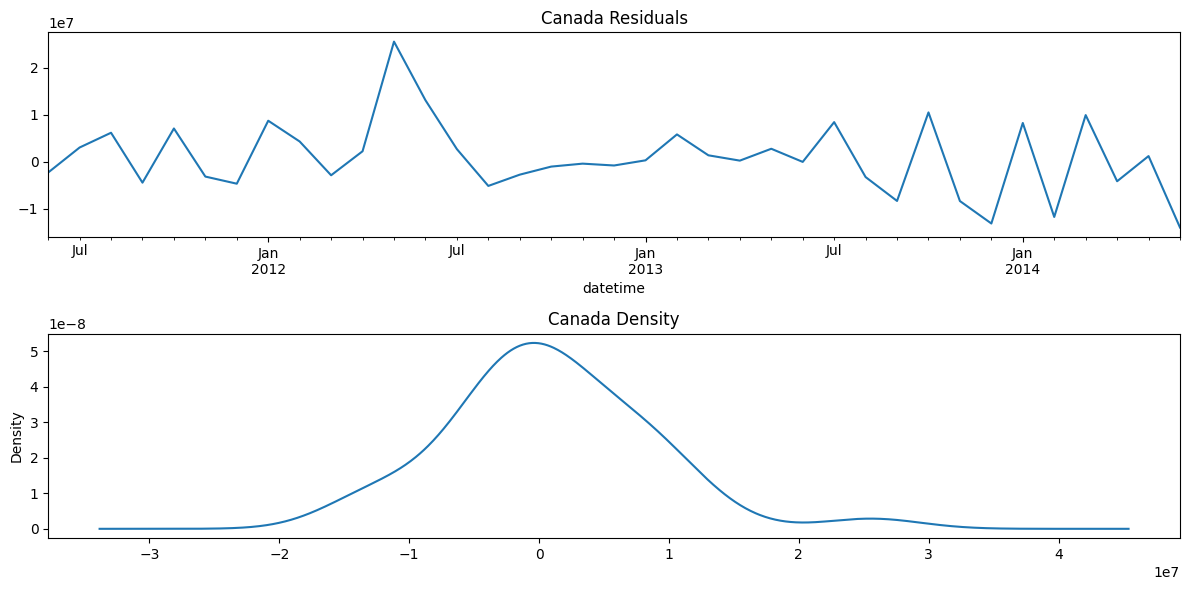

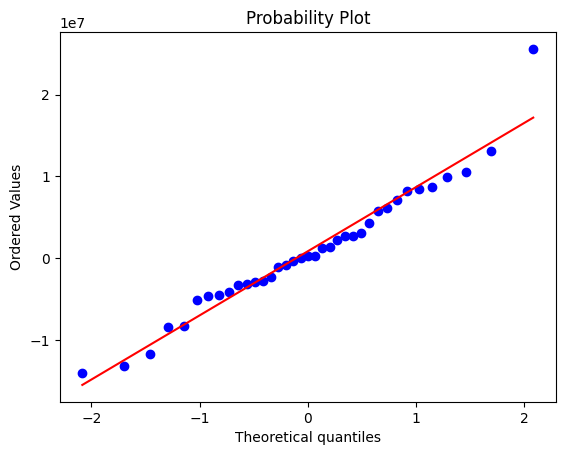

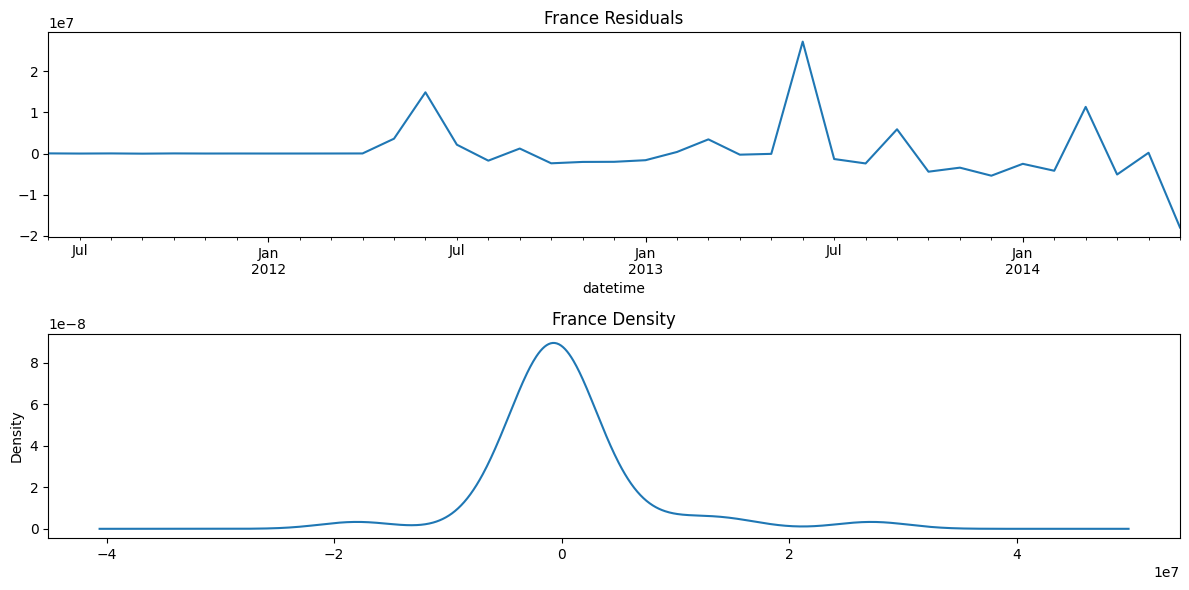

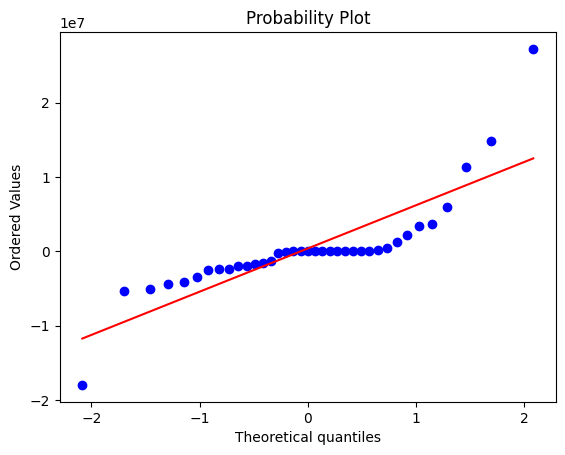

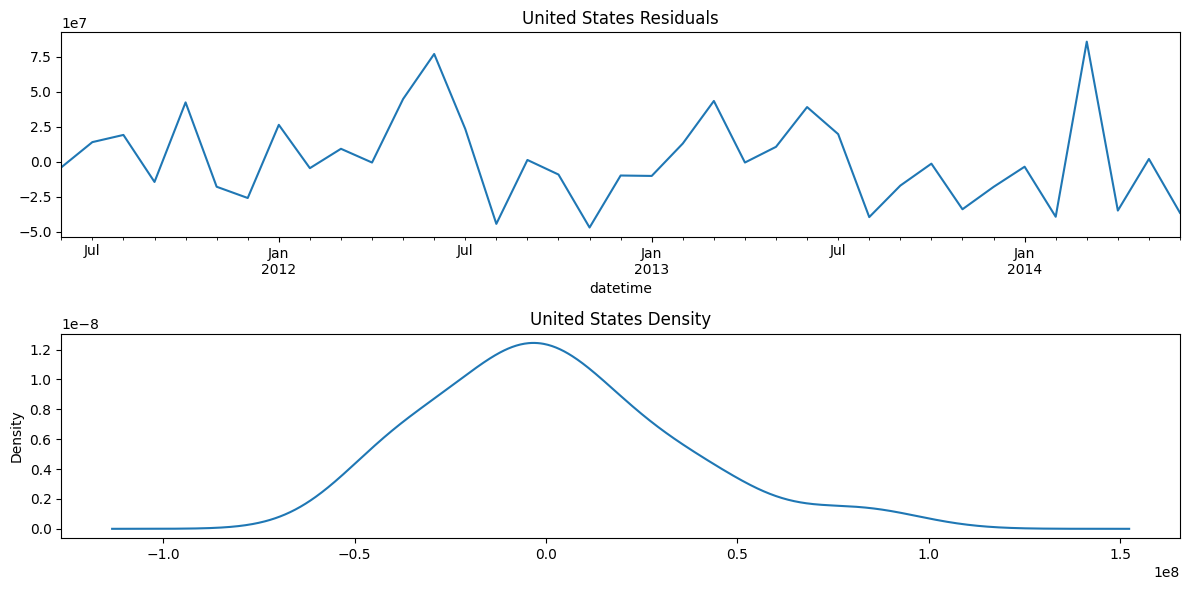

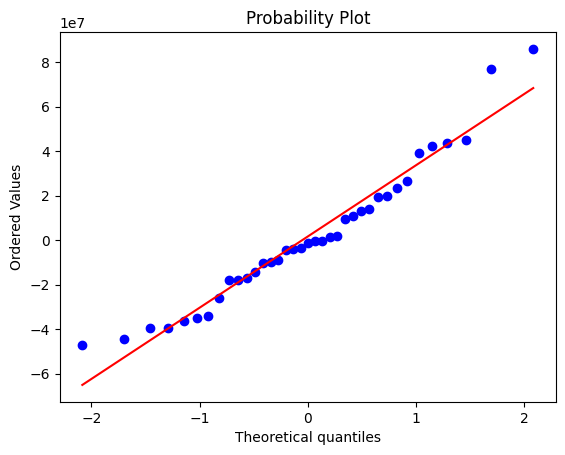

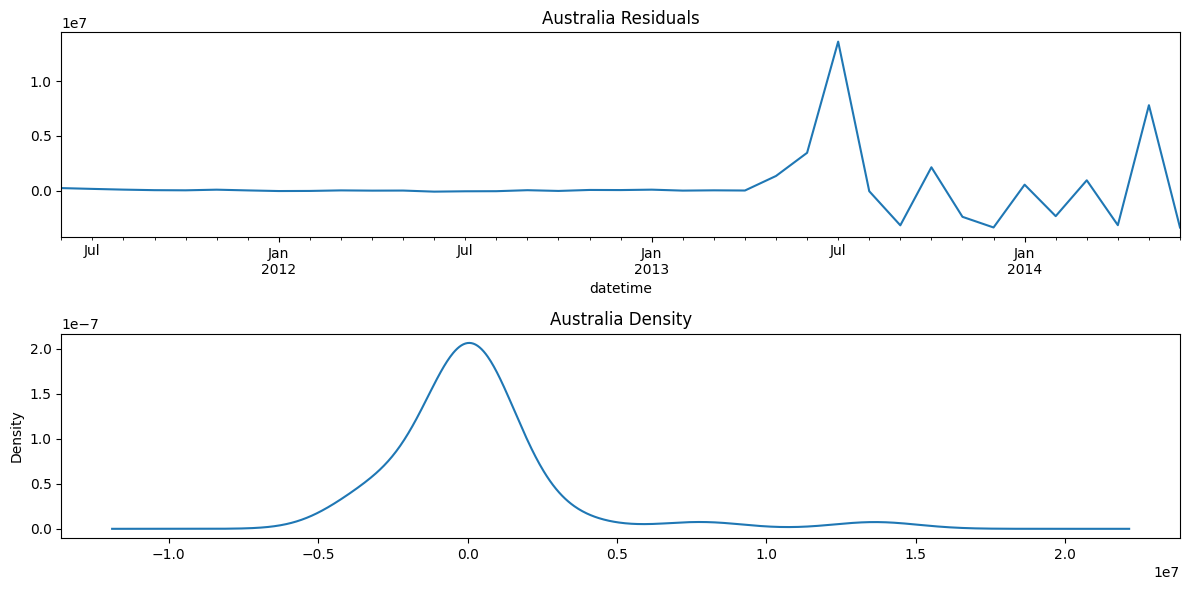

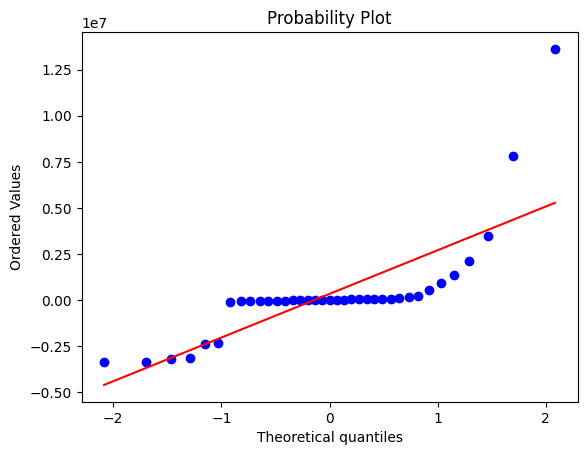

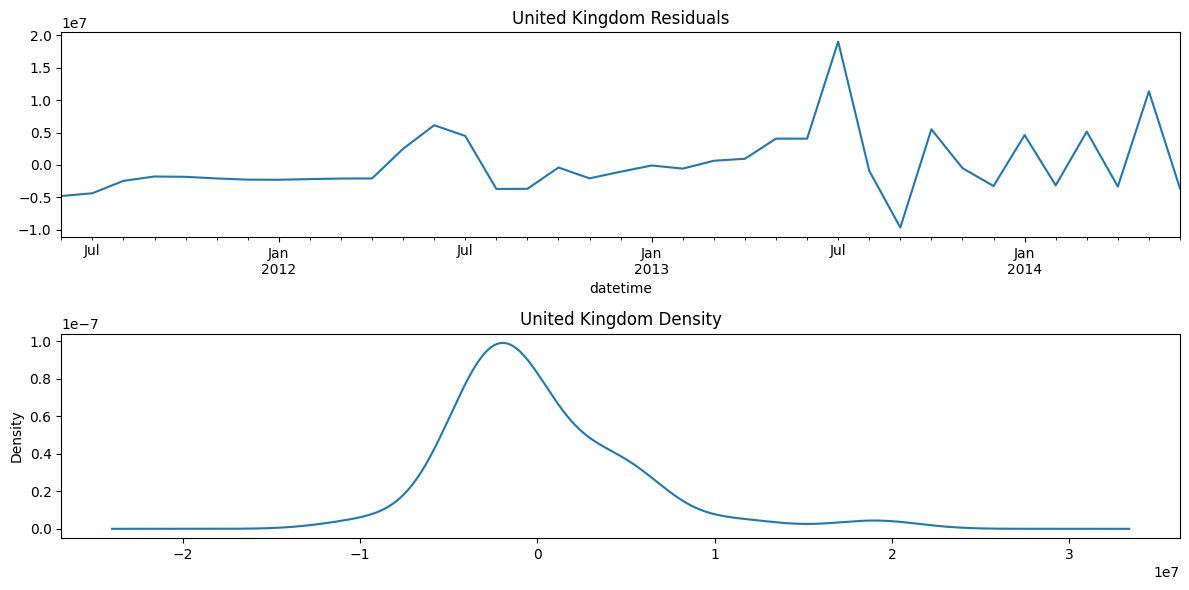

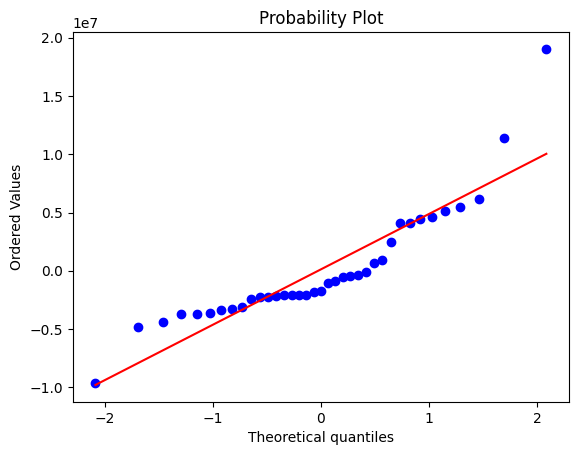

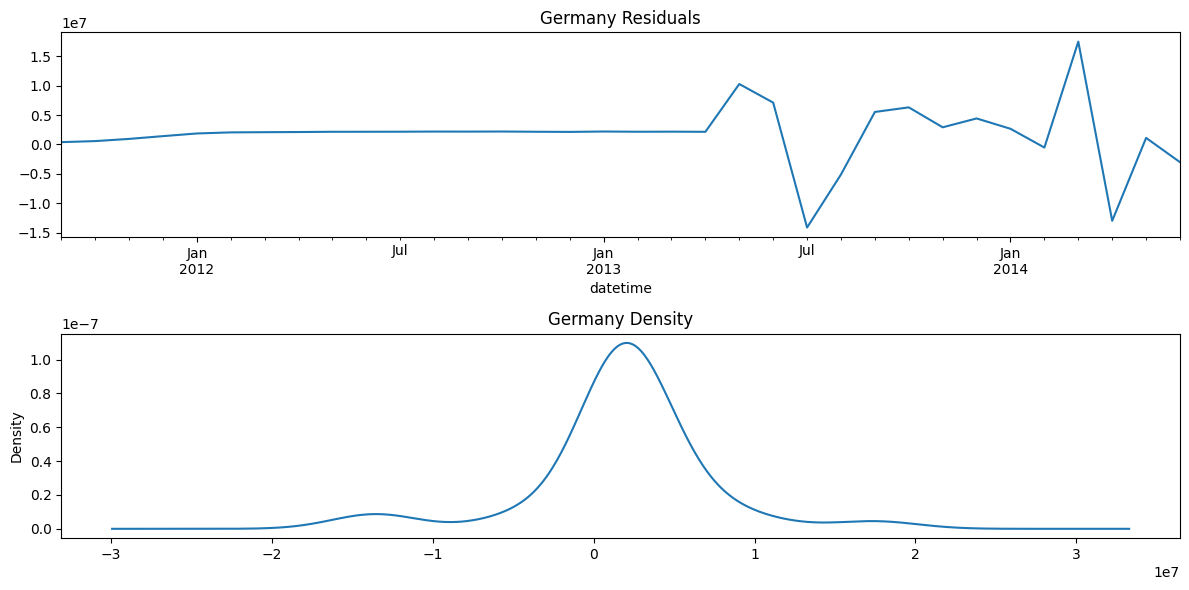

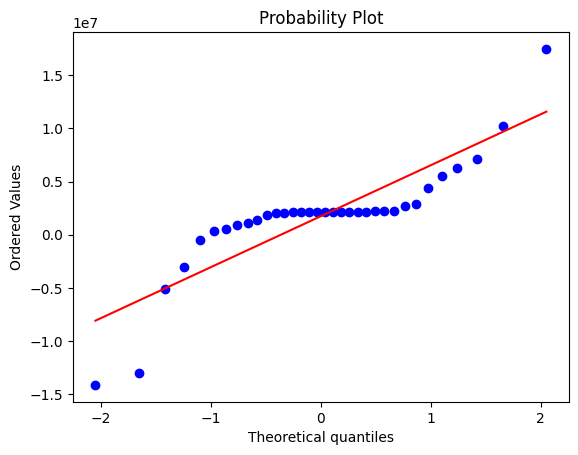

In [34]:
for (country, model) in model_fit_countries.items():
    # Plot residuals
    residuals = model.resid

    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    residuals.plot(title=country + " Residuals", ax=plt.gca())

    plt.subplot(212)
    residuals.plot(kind='kde', title=country + ' Density', ax=plt.gca())

    plt.tight_layout()
    plt.show()

    stats.probplot(residuals, dist="norm", plot=pylab)
    pylab.show()


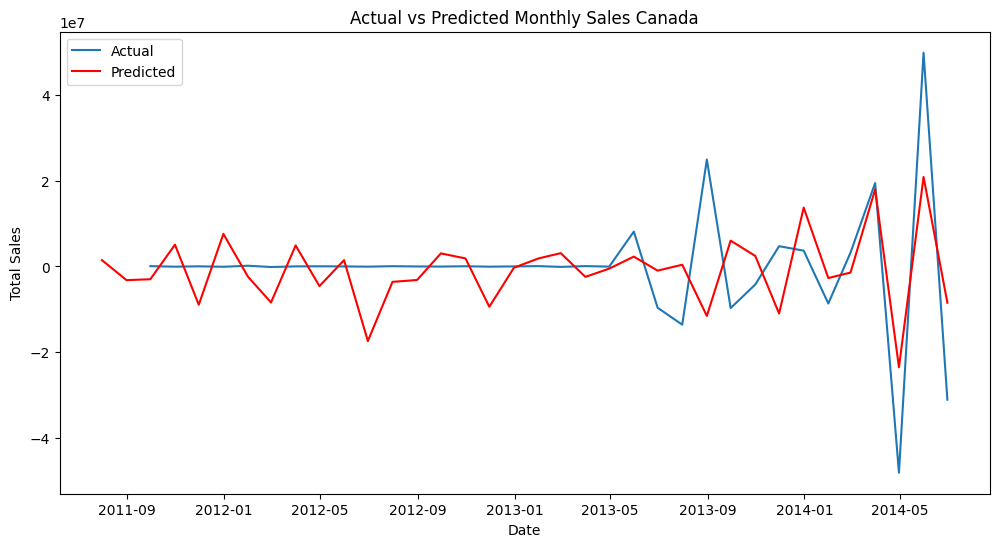

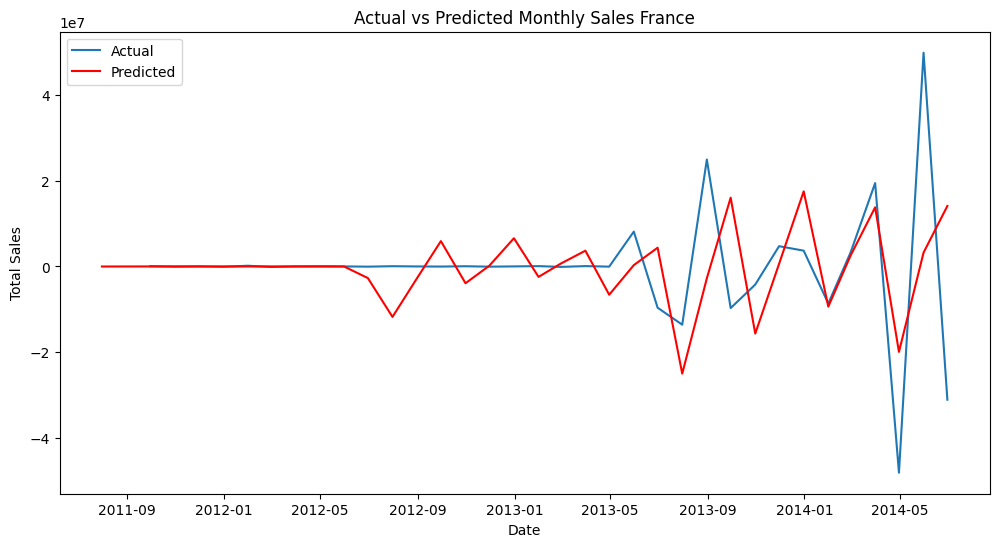

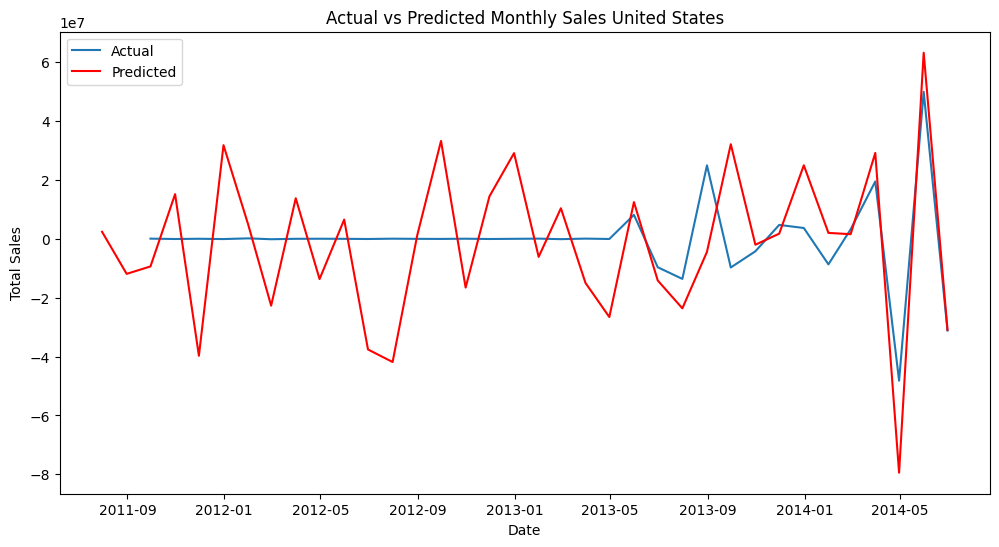

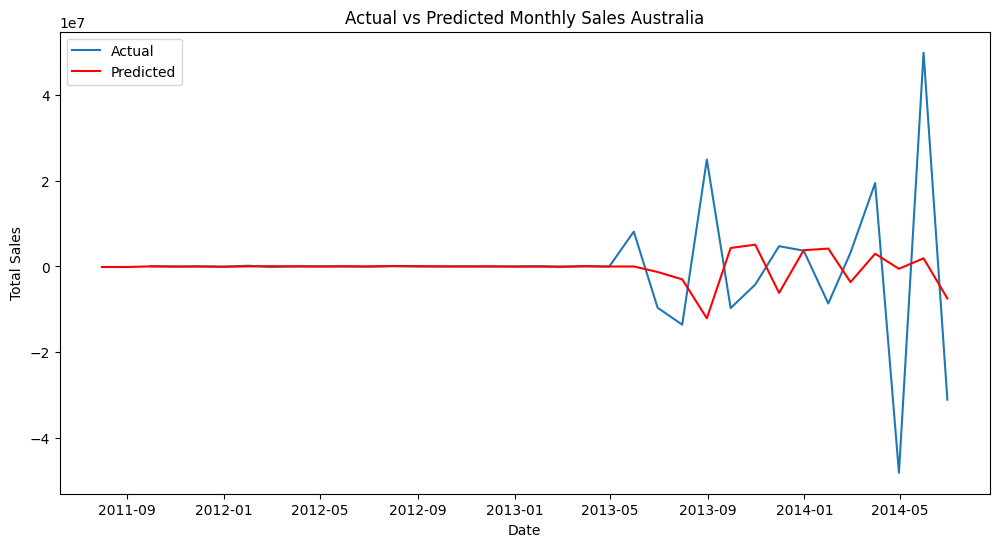

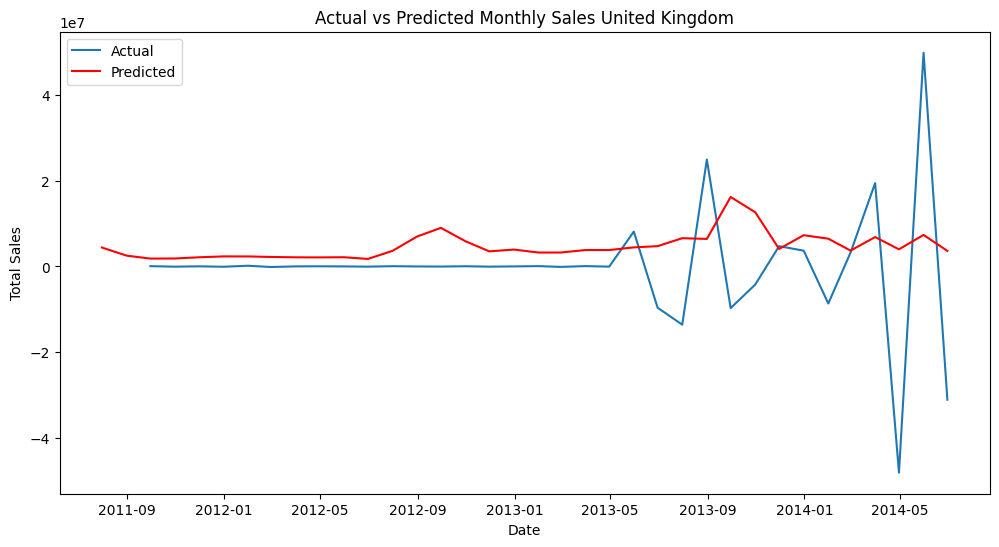

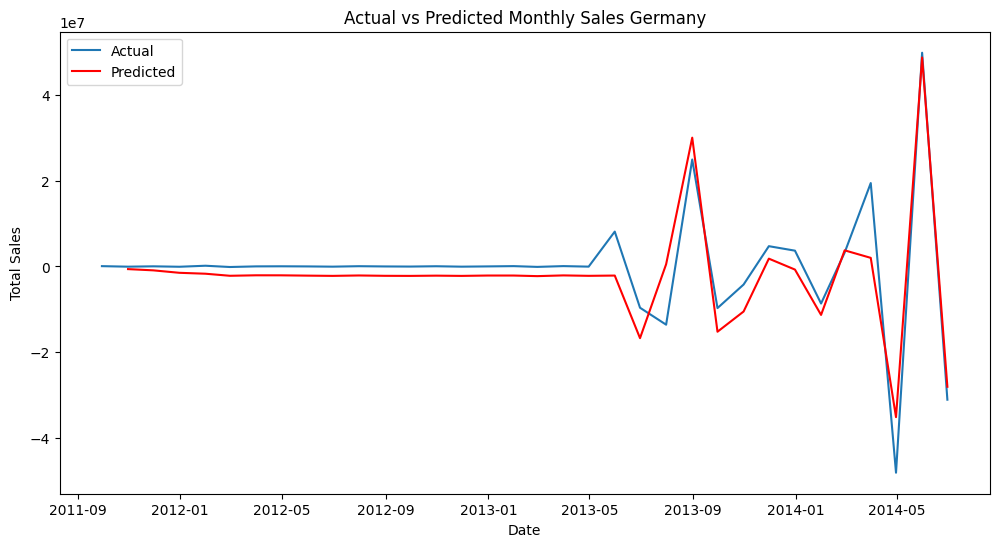

In [35]:
for (country, model) in model_fit_countries.items():
    # In-sample prediction
    predictions = model.predict(start=monthly_sales_by_country[country].index[1], end=monthly_sales_by_country[country].index[-1], typ='levels')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_sales, label='Actual')
    plt.plot(predictions, color='red', label='Predicted')
    plt.title('Actual vs Predicted Monthly Sales ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()


C:\Users\Hi There\AppData\Local\Temp\ipykernel_34568\550083929.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


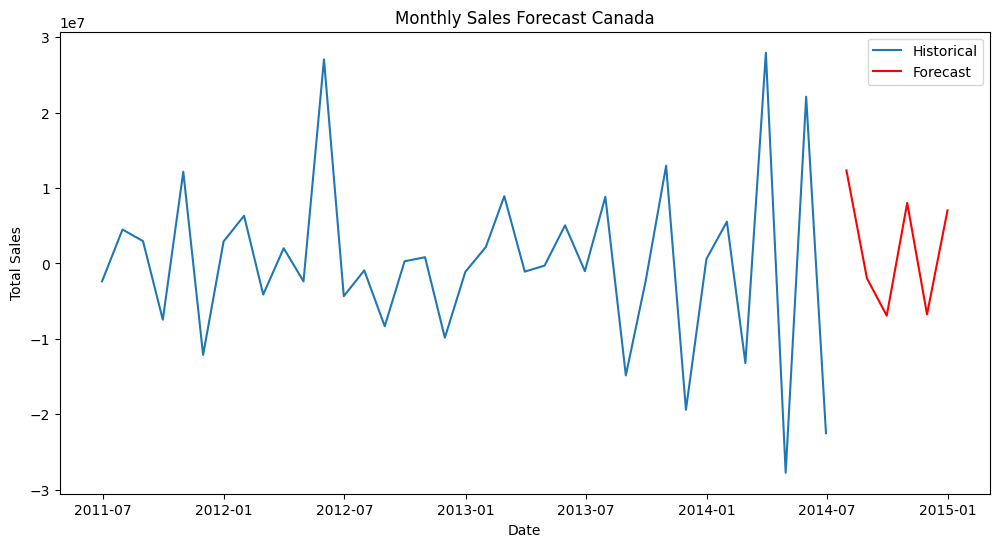

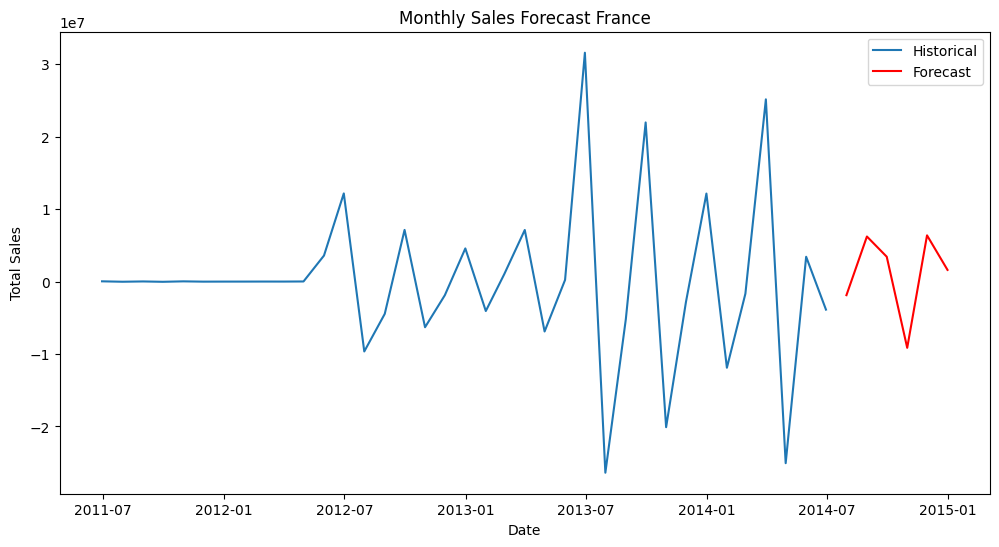

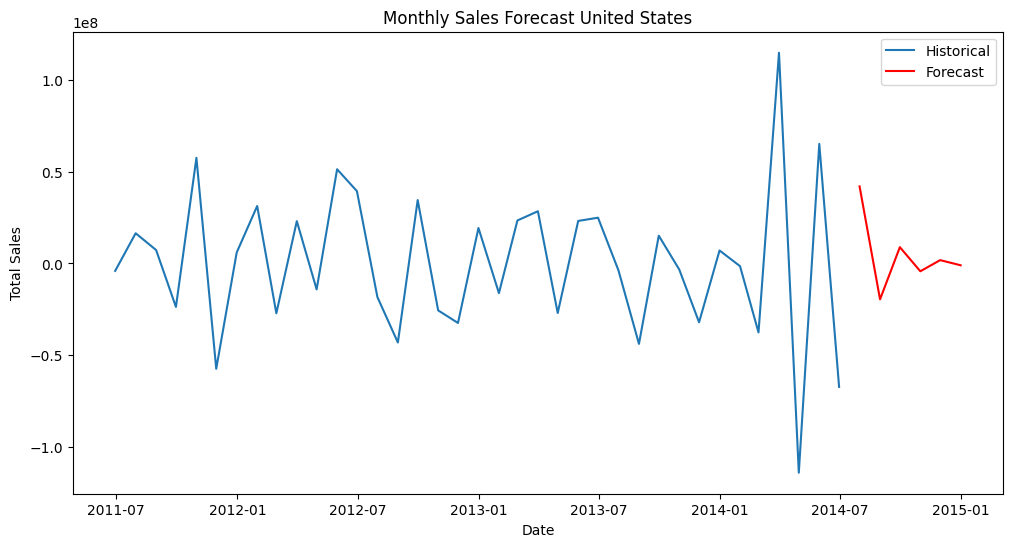

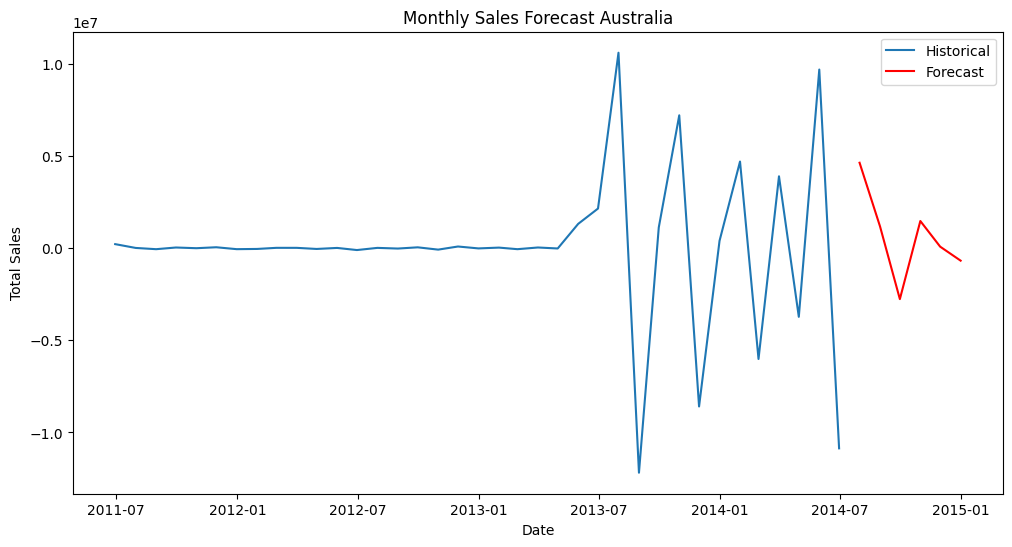

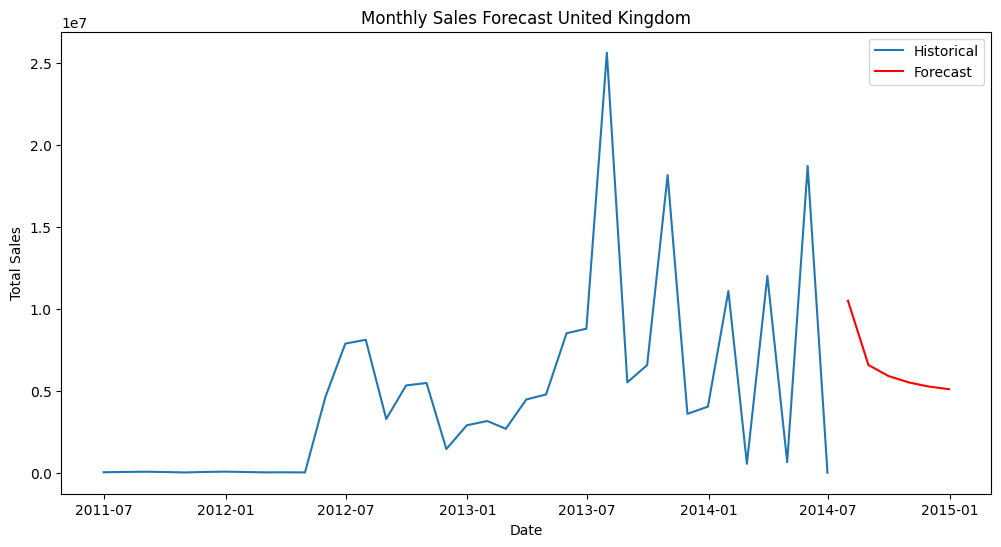

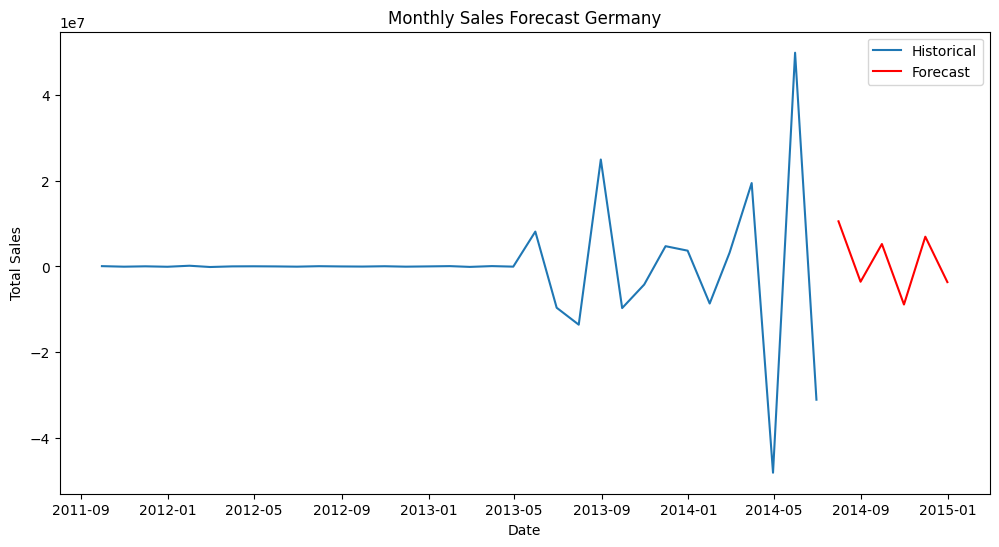

In [36]:
for (country, model) in model_fit_countries.items():
    # Forecasting
    forecast_steps = 6
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = monthly_sales_by_country[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_sales_by_country[country], label='Historical')
    plt.plot(forecast_series, label='Forecast', color='red')
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()

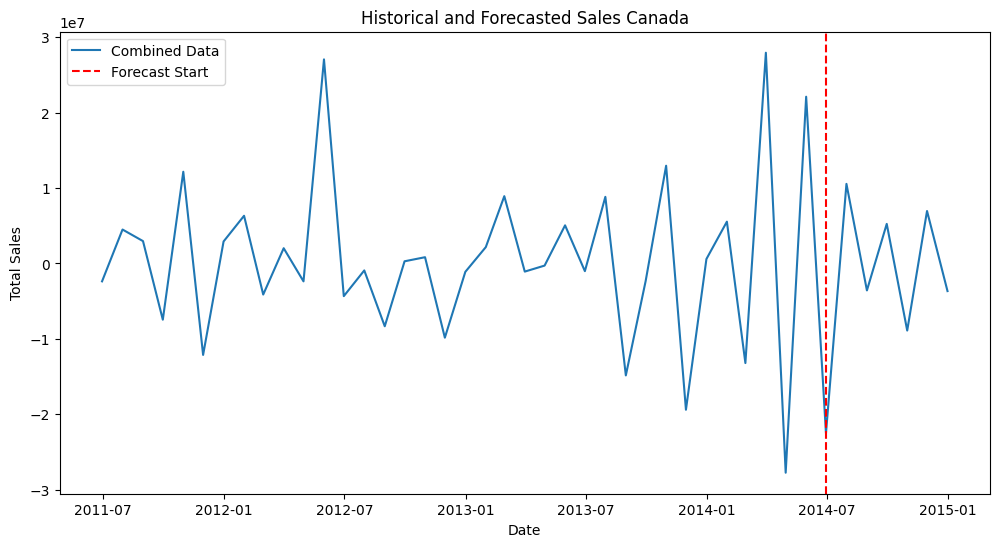

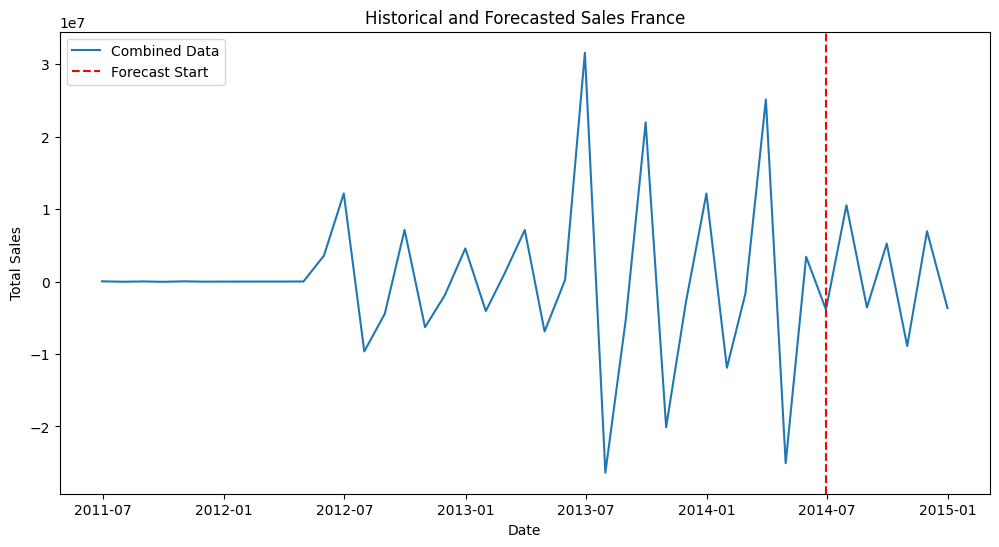

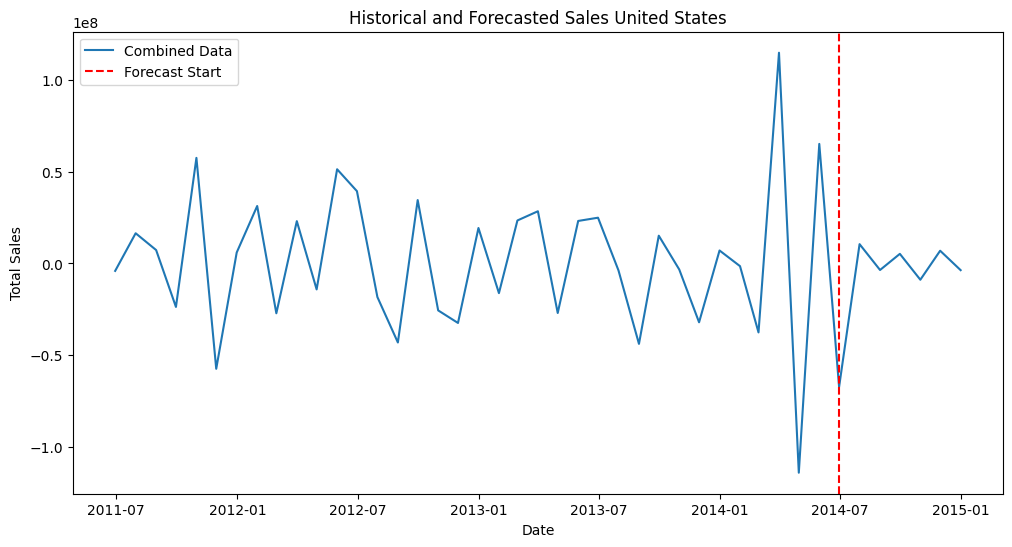

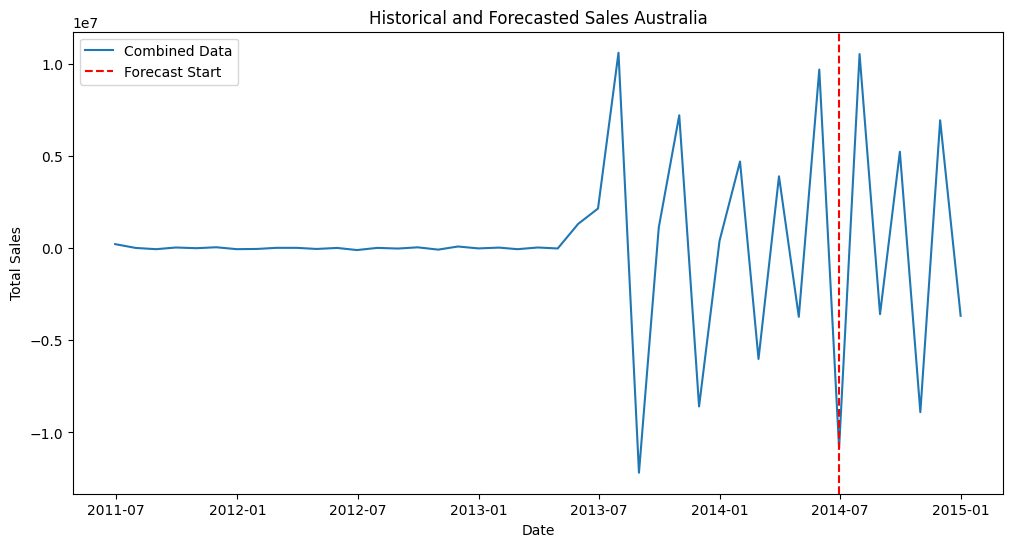

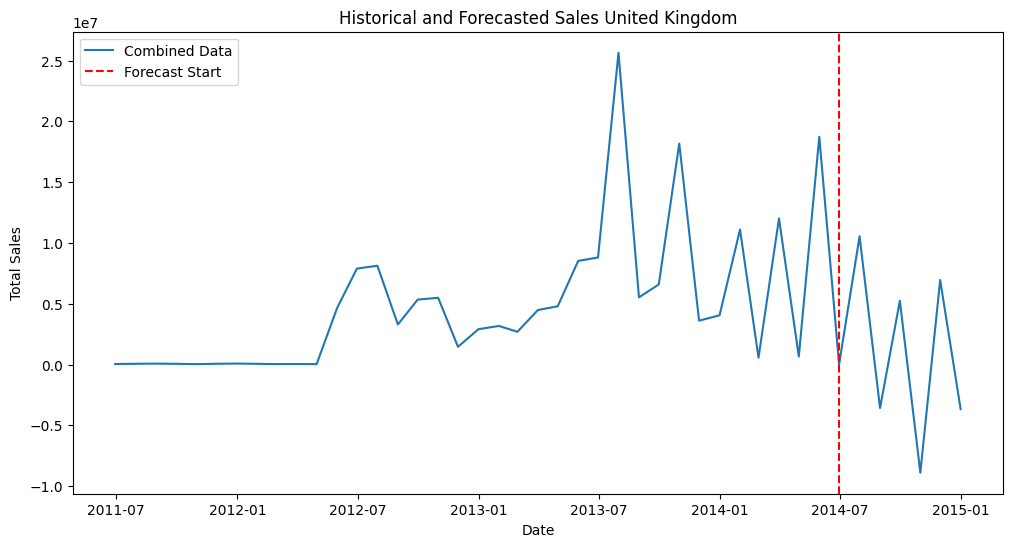

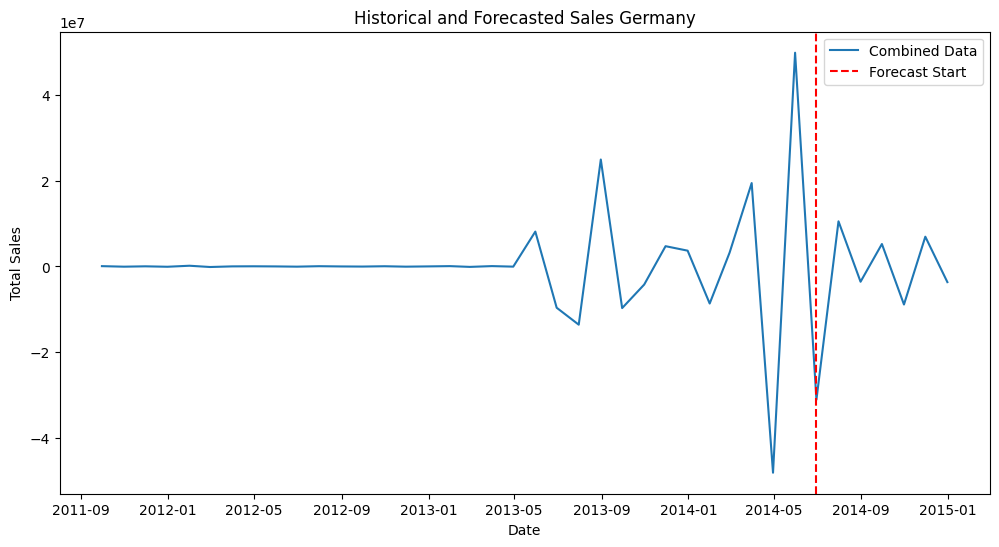

In [37]:
for (country, model) in model_fit_countries.items():
    # Combine historical and forecast data
    combined = pd.concat([monthly_sales_by_country[country], forecast_series], axis=0)

    # Plot combined data
    plt.figure(figsize=(12, 6))
    plt.plot(combined, label='Combined Data')
    plt.axvline(x=monthly_sales.index[-1], color='red', linestyle='--', label='Forecast Start')
    plt.title('Historical and Forecasted Sales ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()
